# IMPORT LIBRARIES

In [1]:
import sys
import random
import re
import os
import collections
import torch
import wandb
import time
import torchvision
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from tqdm import tqdm
from torchinfo import summary
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from PIL import Image
from pathlib import Path
from collections import Counter
from torch.utils.data import Dataset, Subset, DataLoader, DistributedSampler
from concurrent.futures import ThreadPoolExecutor

from SIBI_classifier.logger.logging import log_manager
from SIBI_classifier.utils.main_utils import custom_title_print
from SIBI_classifier.configuration.configuration import ConfigurationManager
from SIBI_classifier.exception import SIBIClassificationException

# SETUP CONSTANTS
In this section, we will define some constants that are important for data processing and model training.
These constants will help us set the dataset folder path, the extension pattern of the image files to be collected, and which folders to access.
Later, these constants will be used in various parts of the code.

In [2]:
CONFIG = ConfigurationManager()
DATA_PREPROCESSING_CONFIG = CONFIG.get_data_preprocessing_config()
DATA_INGESTION_CONFIG = CONFIG.get_data_ingestion_config()
MODEL_TRAINER = CONFIG.get_model_trainer_config()

DATA_PREPROCESSING_LOGGER = log_manager.setup_logger("DataPreprocessingLogger")
MODEL_TRAINER_LOGGER = log_manager.setup_logger("ModelTrainerLogger")

COLLECT_AND_COMBINE_IMAGES_LOGGER = log_manager.setup_logger("collect_and_combine_images_logger")
FILE_PATH_INFO_LOGGER = log_manager.setup_logger("file_path_info_logger")
SPLIT_TRAIN_VALID_TEST_LOGGER = log_manager.setup_logger("split_train_valid_test_logger")
CLASS_DISTRIBUTION_LOGGER = log_manager.setup_logger("class_distribution_logger")
IMAGE_PROCESSING_LOGGER = log_manager.setup_logger("image_processing_logger")
DATASET_INSPECT_LOGGER = log_manager.setup_logger("dataset_inspect_logger")
MODEL_BUILDING_LOGGER = log_manager.setup_logger("model_building_logger")
SETUP_MODEL_LOGGER = log_manager.setup_logger("setup_model_logger")
DATA_BATCHING_LOGGER = log_manager.setup_logger("data_batching_logger")
MODEL_TRAINING_LOGGER = log_manager.setup_logger("model_training_logger")

COLOR_TEXT = "yellow"

[ 2024-12-03 11:27:43 ] create_directories_logger - INFO - created directory at: artifacts
[ 2024-12-03 11:27:43 ] create_directories_logger - INFO - created directory at: artifacts/<model_name>/data_preprocessing/objects
[ 2024-12-03 11:27:43 ] create_directories_logger - INFO - created directory at: artifacts/<model_name>/data_ingestion/SIBI_dataset
[ 2024-12-03 11:27:43 ] create_directories_logger - INFO - created directory at: artifacts/<model_name>/results/model
[ 2024-12-03 11:27:43 ] create_directories_logger - INFO - created directory at: artifacts/<model_name>/results/reports


In [3]:
DATA_PREPROCESSING_LOGGER.info(f"Setting random seed: {log_manager.color_text(DATA_PREPROCESSING_CONFIG.seed, COLOR_TEXT)}")
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU
    # Optional: Ensure determinism in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Setting a seed for reproducibility
set_seed(DATA_PREPROCESSING_CONFIG.seed)

[ 2024-12-03 11:27:43 ] DataPreprocessingLogger - INFO - Setting random seed: 42


# PREPARING DATA WORKFLOW

## Load Data From Folders

### function

In [4]:
def collect_images_with_regex_and_count(
		path: str,
		folder_classes: list,
		extensions_pattern: str
	) -> dict:
	
	"""
	Collects images from specified directories that match a given file extension pattern.

	Args:
		path (str): The root directory path containing the folder classes.
		folder_classes (list): List of folder names representing different classes.
		extensions_pattern (str): Regex pattern to match file extensions.

	Returns:
		dict: A dictionary where keys are folder classes and values are lists of image paths.
	"""
	try:
		# Initialize a dictionary to hold image paths for each class
		image_paths = {folder_class: [] for folder_class in folder_classes}
		
		# Compile the regex pattern for matching file extensions
		pattern = re.compile(str(extensions_pattern), re.IGNORECASE)

		# Iterate over each class folder
		for folder_class in folder_classes:
			folder_path = Path(path) / folder_class

			# Recursively search for files matching the pattern in each class folder
			for file_path in folder_path.rglob("*"):
				if pattern.search(file_path.suffix):
					image_paths[folder_class].append(file_path)

			COLLECT_AND_COMBINE_IMAGES_LOGGER.info(f"Collecting from class {log_manager.color_text(folder_class, COLOR_TEXT)}: {log_manager.color_text(len(image_paths[folder_class]), COLOR_TEXT)} paths found.")

		return image_paths

	except Exception as e:
		# Handle exceptions and return an empty dictionary if no classes are retrieved
		COLLECT_AND_COMBINE_IMAGES_LOGGER.info(f"No classes are retrieved from directory.")
		return {}

In [5]:
def get_random_images(
		image_paths: list,
		num_samples: int,
		seed: int,
	) -> list:
	
	"""
	Retrieves a random number of images from the image path list.
	Args:
		image_paths (list): A list of image paths.
		num_samples (int): The number of images to retrieve. If None, all images will be selected.
		seed (int): Seed to control the random retrieval results so that the results can be reproduced. Default is 42.
	Returns:
		list: A list of randomly selected image paths.
	"""

	try:
		random.seed(seed)
		return random.sample(image_paths, min(len(image_paths) if num_samples is None else num_samples, len(image_paths)))

	except Exception as e:
		raise SIBIClassificationException(e, sys)

In [6]:
def collect_and_combine_images(
		classes: list=[], 
		train_path: str=None, 
		valid_path: str=None,
		test_path: str=None, 
		pattern_regex: str=r"\.(jpe?g)$", 
		num_images_per_class: dict=None, 
		seed: int=42
	) -> list:
	
	"""
	Collects and merges images from the training and validation folders, and retrieves a random number of images from each class.
	Args:
		classes (list): List of classes (folder names) to process.
		train_path (str): The main path of the training folder that contains image data sub-folders.
		valid_path (str): The main path of the validation folder that contains the image data sub-folders.
		pattern_regex (str): The regex pattern for matching image file extensions (e.g. r'\.(jpg|png|jpeg)$').
		num_images_per_class (dict): Dictionary containing the number of images to fetch for each class. If None, all images will be retrieved.
		seed (int): Seed for random image retrieval. Default is 42.
	Returns:
		list: A combined list of image paths from the training and validation folders that were randomly picked.
	"""

	try:
		def process_class(cls):
			# Combine images from training and validation for each class
			all_train_images = train_images_paths.get(cls, [])
			all_valid_images = valid_images_paths.get(cls, [])
			all_test_images = test_images_paths.get(cls, [])
			all_combined_images = all_train_images + all_valid_images + all_test_images

			# Retrieve a random number of images from the combined image
			return get_random_images(
				image_paths=all_combined_images,
				num_samples=None if num_images_per_class is None else num_images_per_class.get(cls, len(all_combined_images)),
				seed=seed
			)

		custom_title_print(f"COLLECT {classes} FROM TRAINING DATA")
		train_images_paths = collect_images_with_regex_and_count(train_path, classes, pattern_regex)
		custom_title_print(f"=")

		# Print the title for the image collection process of the validation data
		custom_title_print(f"COLLECT {classes} FROM VALIDATION DATA")
		valid_images_paths = collect_images_with_regex_and_count(valid_path, classes, pattern_regex)
		custom_title_print(f"=")

		# Print the title for the image collection process of the test data
		custom_title_print(f"COLLECT {classes} FROM TEST DATA")
		test_images_paths = collect_images_with_regex_and_count(test_path, classes, pattern_regex)
		custom_title_print(f"=")

		# Print titles for the process of merging images from training and validation
		custom_title_print(f"COMBINING {classes} FROM TRAINING AND VALIDATION DATA")

		random_images = {}

		# Using ThreadPoolExecutor to speed up the process of fetching images from each class in parallel
		with ThreadPoolExecutor() as executor:
			results = executor.map(process_class, classes)

		# Store the random image results for each class into the dictionary
		for cls, images in zip(classes, results):
			random_images[cls] = images
			COLLECT_AND_COMBINE_IMAGES_LOGGER.info(f"Total {log_manager.color_text(cls, 'yellow')} taken: {log_manager.color_text(len(random_images[cls]), 'yellow')}")

		# Merge all image paths from all classes
		all_images_paths = sum(random_images.values(), [])
		all_images_paths = [str(path) for path in all_images_paths]
		custom_title_print(f"Total images taken: {len(all_images_paths)}")

		return all_images_paths

	except Exception as e:
		raise SIBIClassificationException(e, sys)

### main program

In [7]:
DATA_PREPROCESSING_LOGGER.info("Collecting and combining images from training and validation folders...")

all_images_paths = collect_and_combine_images(
    classes = DATA_PREPROCESSING_CONFIG.label_list,
    train_path  = DATA_INGESTION_CONFIG.data_download_store_train_dir_path,
    pattern_regex = DATA_PREPROCESSING_CONFIG.image_extension_regex,
    seed= DATA_PREPROCESSING_CONFIG.seed
)

[ 2024-12-03 11:27:44 ] DataPreprocessingLogger - INFO - Collecting and combining images from training and validation folders...
[ 2024-12-03 11:27:44 ] title_print_logger - INFO - COLLECT ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] FROM TRAINING DATA
[ 2024-12-03 11:27:44 ] collect_and_combine_images_logger - INFO - Collecting from class A: 200 paths found.
[ 2024-12-03 11:27:44 ] collect_and_combine_images_logger - INFO - Collecting from class B: 200 paths found.
[ 2024-12-03 11:27:44 ] collect_and_combine_images_logger - INFO - Collecting from class C: 200 paths found.
[ 2024-12-03 11:27:44 ] collect_and_combine_images_logger - INFO - Collecting from class D: 200 paths found.
[ 2024-12-03 11:27:44 ] collect_and_combine_images_logger - INFO - Collecting from class E: 200 paths found.
[ 2024-12-03 11:27:44 ] collect_and_combine_images_logger - INFO - Collecting from class F: 200 paths found.
[ 2024-

## Display file paths info

### function

In [8]:
class FilePathInfo:
    def __init__(
            self, 
            unit_file_size: str='bytes'
        ) -> None:
        
        self.unit_file_size = unit_file_size.lower()
        self.units = ['bytes', 'kb', 'mb', 'gb']
        if self.unit_file_size not in self.units:
            raise ValueError(f"Invalid unit. Choose from {self.units}.")

    def show_train_files_path_info(
            self, 
            files_path_data: list=[], 
            is_random: bool=False
        ) -> int:

        files_path_data_plot = random.choice(files_path_data) if is_random else files_path_data[0]
        label_index = self.__display_path_info(files_path_data_plot, is_labeled=True)
        return label_index

    def show_test_files_path_info(
            self, 
            files_path_data: list=[], 
            is_random: bool=False
        ) -> None:

        files_path_data_plot = random.choice(files_path_data) if is_random else files_path_data[0]
        self.__display_path_info(files_path_data_plot, is_labeled=False)

    def __display_path_info(
            self, 
            file_path: str, 
            is_labeled: bool
        ) -> int:

        custom_title_print(' PATH INFO ')
        FILE_PATH_INFO_LOGGER.info(f'File Path: {log_manager.color_text(file_path, COLOR_TEXT)}')

        split_file_path = file_path.split(os.path.sep)
        self.__display_split_file_path(split_file_path)

        if is_labeled:
            kind_data = split_file_path[-3]
            index_label = self.__display_kind_data_info(split_file_path, kind_data)
            self.__display_file_info(split_file_path, file_path)
            return index_label
        else:
            self.__display_file_info(split_file_path, file_path)

    def __display_split_file_path(
            self, 
            split_file_path: list
        ) -> None:
        
        custom_title_print(' SPLIT FILE PATH ')
        FILE_PATH_INFO_LOGGER.info(f'Split File Path: {log_manager.color_text(split_file_path, COLOR_TEXT)}')

        custom_title_print(' INDEXED PATH ')
        result = {value: f'Index -> {index}' for index, value in enumerate(split_file_path)}
        for key, value in result.items():
            FILE_PATH_INFO_LOGGER.info(f'{log_manager.color_text(value, COLOR_TEXT)}: {log_manager.color_text(key, COLOR_TEXT)}')

    def __display_kind_data_info(
            self, 
            split_file_path: list, 
            kind_data: str
        ) -> int:
        
        custom_title_print(f' KIND DATA INDEX {kind_data} ')
        index = split_file_path.index(kind_data)
        FILE_PATH_INFO_LOGGER.info(f'Index of "{log_manager.color_text(kind_data, COLOR_TEXT)}": {log_manager.color_text(index, COLOR_TEXT)}')

        index_label = index + 1
        custom_title_print(' INDEX LABEL ')
        FILE_PATH_INFO_LOGGER.info(f'Index Label: {log_manager.color_text(index_label, COLOR_TEXT)}')

        custom_title_print(' LABEL ')
        FILE_PATH_INFO_LOGGER.info(f'Label: {log_manager.color_text(split_file_path[index_label], COLOR_TEXT)}')

        return index_label

    def __display_file_info(
            self, 
            split_file_path: list, 
            file_path: str
        ) -> None:
        
        file_name = split_file_path[-1]
        custom_title_print(' FILE NAME ')
        FILE_PATH_INFO_LOGGER.info(f'File Name: {log_manager.color_text(file_name, COLOR_TEXT)}')

        file_extension = os.path.splitext(file_name)[1]
        custom_title_print(' FILE EXTENSION ')
        FILE_PATH_INFO_LOGGER.info(f'File Extension: {log_manager.color_text(file_extension, COLOR_TEXT)}')

        image_size = Image.open(file_path).size
        custom_title_print(' IMAGE SIZE (PX)')
        FILE_PATH_INFO_LOGGER.info(f'Image Size: width={log_manager.color_text(image_size[0], COLOR_TEXT)}, height={log_manager.color_text(image_size[1], COLOR_TEXT)}')

        file_size = os.path.getsize(file_path)
        file_size = self.__format_file_size(file_size)
        custom_title_print(' FILE SIZE ')
        FILE_PATH_INFO_LOGGER.info(f'File Size: {log_manager.color_text(file_size, COLOR_TEXT)} {log_manager.color_text(self.unit_file_size, COLOR_TEXT)}')


    def __format_file_size(
            self, 
            size: int
        ) -> float:

        match self.unit_file_size:
            case 'kb':
                size /= 1024
            case 'mb':
                size /= 1024 ** 2
            case 'gb':
                size /= 1024 ** 3
            case _:
                size = size # default is bytes
        
        size = round(size, 4)

        return size

In [9]:
print(f'first data: {all_images_paths[0]}')
print(f'number of data: {len(all_images_paths)}')

first data: artifacts/<model_name>/data_ingestion/SIBI_dataset/Train/A/image_A_(1723068087.4824092).jpg
number of data: 5200


In [10]:
DATA_PREPROCESSING_LOGGER.info("Displaying file path information...")
file_info  = FilePathInfo(unit_file_size='kb')

[ 2024-12-03 11:27:44 ] DataPreprocessingLogger - INFO - Displaying file path information...


In [11]:
LABEL_INDEX = file_info.show_train_files_path_info(all_images_paths, is_random=True)

[ 2024-12-03 11:27:44 ] title_print_logger - INFO - =================== PATH INFO ====================
[ 2024-12-03 11:27:44 ] file_path_info_logger - INFO - File Path: artifacts/<model_name>/data_ingestion/SIBI_dataset/Train/W/image_W_(1723083370.198182).jpg
[ 2024-12-03 11:27:44 ] title_print_logger - INFO - ================ SPLIT FILE PATH =================
[ 2024-12-03 11:27:45 ] file_path_info_logger - INFO - Split File Path: ['artifacts', '<model_name>', 'data_ingestion', 'SIBI_dataset', 'Train', 'W', 'image_W_(1723083370.198182).jpg']
[ 2024-12-03 11:27:45 ] title_print_logger - INFO - ================== INDEXED PATH ==================
[ 2024-12-03 11:27:45 ] file_path_info_logger - INFO - Index -> 0: artifacts
[ 2024-12-03 11:27:45 ] file_path_info_logger - INFO - Index -> 1: <model_name>
[ 2024-12-03 11:27:45 ] file_path_info_logger - INFO - Index -> 2: data_ingestion
[ 2024-12-03 11:27:45 ] file_path_info_logger - INFO - Index -> 3: SIBI_dataset
[ 2024-12-03 11:27:45 ] file_p

## Convert to Pytorch Dataset

### function

In [12]:
class ImageDataset(Dataset):
    def __init__(
            self, 
            file_paths: list, 
            label_index: int
        ) -> None:
        
        """
        Dataset for a list of image files.
        :param file_paths: List paths to images.
        """
        self.file_paths = file_paths
        self.label_index = label_index

    def __len__(self) -> int:
        return len(self.file_paths)

    def __getitem__(
            self, 
            idx: int
        ) -> tuple:
        
        split_text = self.file_paths[idx].split(os.path.sep)
        label = split_text[self.label_index]
        return self.file_paths[idx], label

### main program

In [13]:
DATA_PREPROCESSING_LOGGER.info("Creating PyTorch dataset...")
pytorch_paths = ImageDataset(all_images_paths, LABEL_INDEX)

[ 2024-12-03 11:27:45 ] DataPreprocessingLogger - INFO - Creating PyTorch dataset...


In [14]:
pytorch_paths[0]

('artifacts/<model_name>/data_ingestion/SIBI_dataset/Train/A/image_A_(1723068087.4824092).jpg',
 'A')

## Split Data

### function

In [15]:
class DatasetSplitter:
    def __init__(self):
        pass

    def split_train_valid_test(
            self, 
            dataset: Dataset=None, 
            split_ratio: tuple=None, 
            shuffle: bool=True, 
            seed: int=42
        ) -> tuple:
        
        if split_ratio is None or len(split_ratio) < 2:
            raise ValueError("split_ratio must be of the form (train_ratio, val_ratio).")

        train_ratio, val_ratio = split_ratio
        test_ratio = max(1.0 - (train_ratio + val_ratio), 0)

        total_ratio = round(sum((train_ratio, val_ratio, test_ratio)), 2)
        if total_ratio != 1.0:
            raise ValueError("[ERROR] split_ratio must sum to 1.0.")

        dataset_size = len(dataset)
        labels = [data[1] for data in dataset]  # Assuming dataset[i] = (data, label)

        # Stratified split for train and remaining (val + test)
        train_idx, temp_idx, _, temp_labels = train_test_split(
            list(range(dataset_size)),
            labels,
            test_size=(val_ratio + test_ratio) if (val_ratio + test_ratio) > 0 else None,
            stratify=labels if labels else None,
            random_state=seed,
        )

        if test_ratio > 0:  # If test_ratio > 0, perform stratified split for val and test
            val_size_ratio = val_ratio / (val_ratio + test_ratio)
            val_idx, test_idx, _, _ = train_test_split(
                temp_idx,
                temp_labels,
                test_size=(1 - val_size_ratio),
                stratify=temp_labels if temp_labels else None,
                random_state=seed,
            )
        else:  # If test_ratio == 0, assign all remaining data to validation
            val_idx = temp_idx
            test_idx = []

        train_dataset = Subset(dataset, train_idx)
        val_dataset = Subset(dataset, val_idx)
        test_dataset = Subset(dataset, test_idx)

        self.__display_info(
            dataset_size=dataset_size,
            train_dataset=train_dataset,
            valid_dataset=val_dataset,
            test_dataset=test_dataset,
            shuffle=shuffle,
        )

        return train_dataset, val_dataset, test_dataset

    def __display_info(
            self, 
            dataset_size: int, 
            train_dataset: Dataset, 
            valid_dataset: Dataset, 
            test_dataset: Dataset, 
            shuffle: bool
        ) -> None:
        
        """
        Displays information about the split dataset.
        """
        train_ratio = len(train_dataset) / dataset_size
        valid_ratio = len(valid_dataset) / dataset_size
        test_ratio = len(test_dataset) / dataset_size

        SPLIT_TRAIN_VALID_TEST_LOGGER.info(f"Total number of data: {log_manager.color_text(dataset_size, COLOR_TEXT)}")
        SPLIT_TRAIN_VALID_TEST_LOGGER.info(f"Shuffle status: {log_manager.color_text(shuffle, COLOR_TEXT)}")
        SPLIT_TRAIN_VALID_TEST_LOGGER.info(f"Training Dataset: {log_manager.color_text(len(train_dataset), COLOR_TEXT)} ({log_manager.color_text(f'{train_ratio * 100:.2f}%', COLOR_TEXT)})")
        SPLIT_TRAIN_VALID_TEST_LOGGER.info(f"Validation Dataset: {log_manager.color_text(len(valid_dataset), COLOR_TEXT)} ({log_manager.color_text(f'{valid_ratio * 100:.2f}%', COLOR_TEXT)})")
        SPLIT_TRAIN_VALID_TEST_LOGGER.info(f"Test Dataset: {log_manager.color_text(len(test_dataset), COLOR_TEXT)} ({log_manager.color_text(f'{test_ratio * 100:.2f}%', COLOR_TEXT)})")

### main program

In [16]:
DATA_PREPROCESSING_LOGGER.info("Splitting dataset...")
splitter = DatasetSplitter()

[ 2024-12-03 11:27:45 ] DataPreprocessingLogger - INFO - Splitting dataset...


In [17]:
train_pt_paths, val_pt_paths, _ = splitter.split_train_valid_test(
    pytorch_paths, 
    split_ratio=(0.8, 0.2),
    shuffle=True,
    seed=42
)

[ 2024-12-03 11:27:45 ] split_train_valid_test_logger - INFO - Total number of data: 5200
[ 2024-12-03 11:27:45 ] split_train_valid_test_logger - INFO - Shuffle status: True
[ 2024-12-03 11:27:45 ] split_train_valid_test_logger - INFO - Training Dataset: 4160 (80.00%)
[ 2024-12-03 11:27:45 ] split_train_valid_test_logger - INFO - Validation Dataset: 1040 (20.00%)
[ 2024-12-03 11:27:45 ] split_train_valid_test_logger - INFO - Test Dataset: 0 (0.00%)


## Class Distribution

### function

In [18]:
def calculate_class_distribution_torch(
        dataset: Dataset=None, 
        class_labels: list=None
    ) -> tuple:
    
    """
    Calculates the class distribution and class weights for the PyTorch dataset.

    :param dataset: PyTorch dataset (torch.utils.data.Dataset or torch.utils.data.Subset)
    :param class_labels: List of class labels (list).
    return: Tuple (class_counts, class_weights).
    """
    try:
        # Retrieve all labels from the dataset
        class_names = [data[1] for data in dataset]
        
        # Count the number of each class
        class_counts = Counter(class_names)

        # Convert to index based on class_labels order
        class_indices = [class_labels.index(name) for name in class_names]

        # Calculate class weights using sklearn
        class_weight_values = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(class_indices),
            y=class_indices
        )

        # Membuat kamus untuk bobot kelas
        class_weights = {i: weight for i, weight in enumerate(class_weight_values)}

        return class_counts, class_weights

    except Exception as e:
        raise SIBIClassificationException(e, sys)

In [19]:
def print_class_distribution(
        distribution: collections.Counter=None
    ) -> None:

    """
    Prints the class distribution to the screen.
    Args:
        distribution(collections.Counter): A Counter object containing the class distribution.
    """
    try:
        for class_name, count in sorted(distribution.items()):
            CLASS_DISTRIBUTION_LOGGER.info(f"class {log_manager.color_text(class_name, COLOR_TEXT)}: {log_manager.color_text(count, COLOR_TEXT)} items")

    except Exception as e:
        raise SIBIClassificationException(e, sys)

### main program

In [20]:
DATA_PREPROCESSING_LOGGER.info("Calculating training class distribution...")
train_class_distribution, _ = calculate_class_distribution_torch(
    dataset=train_pt_paths, 
    class_labels=DATA_PREPROCESSING_CONFIG.label_list
)

custom_title_print("Class distribution on Train set:")
print_class_distribution(train_class_distribution)

[ 2024-12-03 11:27:45 ] DataPreprocessingLogger - INFO - Calculating training class distribution...
[ 2024-12-03 11:27:45 ] title_print_logger - INFO - =========CLASS DISTRIBUTION ON TRAIN SET:=========
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class A: 160 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class B: 160 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class C: 160 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class D: 160 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class E: 160 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class F: 160 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class G: 160 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class H: 160 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class I: 160 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class J: 160 items
[ 2024-12-03 11:2

In [21]:
DATA_PREPROCESSING_LOGGER.info("Calculating validation class distribution...")
valid_class_distribution, _ = calculate_class_distribution_torch(
    dataset=val_pt_paths, 
    class_labels=DATA_PREPROCESSING_CONFIG.label_list
)

custom_title_print("Class distribution in Validation set:")
print_class_distribution(valid_class_distribution)

[ 2024-12-03 11:27:45 ] DataPreprocessingLogger - INFO - Calculating validation class distribution...
[ 2024-12-03 11:27:45 ] title_print_logger - INFO - ======CLASS DISTRIBUTION IN VALIDATION SET:=======
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class A: 40 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class B: 40 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class C: 40 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class D: 40 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class E: 40 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class F: 40 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class G: 40 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class H: 40 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class I: 40 items
[ 2024-12-03 11:27:45 ] class_distribution_logger - INFO - class J: 40 items
[ 2024-12-03 11:27:45 ] c

## Data Augmentation

### function

In [22]:
class ImageProcessor:
    def __init__(
            self, 
            image_size: tuple=(224, 224),
            brightness: tuple=(0.5, 1.5),
            contrast: tuple=(0.5, 1.5),
            saturation: tuple=(0.5, 1.5),
            hue: tuple=(-0.5, 0.5),
            p: float=0.5
        ):

        self.image_size = image_size
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.p = p

    def image_resizing(self) -> transforms.Resize:
        IMAGE_PROCESSING_LOGGER.info(f"Resizing image to {log_manager.color_text(self.image_size, COLOR_TEXT)}")
        return  transforms.Resize(
            size=self.image_size[:2],
            interpolation=transforms.InterpolationMode.BILINEAR
        )

    def color_jitter(self) -> transforms.ColorJitter:
        IMAGE_PROCESSING_LOGGER.info(
            f"Color jittering with "
            f"brightness {log_manager.color_text(self.brightness, COLOR_TEXT)}, " 
            f"contrast {log_manager.color_text(self.contrast, COLOR_TEXT)}, " 
            f"saturation {log_manager.color_text(self.saturation, COLOR_TEXT)}, "
            f"hue {log_manager.color_text(self.hue, COLOR_TEXT)}"
        )
        return transforms.ColorJitter(
            brightness=self.brightness, 
            contrast=self.contrast, 
            saturation=self.saturation, 
            hue=self.hue
        )

    def hFlip(self) -> transforms.RandomHorizontalFlip:
        IMAGE_PROCESSING_LOGGER.info(f"Horizontal Flipping with probability {log_manager.color_text(self.p, COLOR_TEXT)}")
        return transforms.RandomHorizontalFlip(p=self.p)

    def vFlip(self) -> transforms.RandomVerticalFlip:
        IMAGE_PROCESSING_LOGGER.info(f"Vertical Flipping with probability {log_manager.color_text(self.p, COLOR_TEXT)}")
        return transforms.RandomVerticalFlip(p=self.p)

In [23]:
class ConvertPathsToTensor(Dataset):
    def __init__(
            self, 
            datasets: list=None, 
            label_list: list=None, 
            seed: int=None, 
            transform: transforms=None
        ):
        
        """
        Dataset for a list of image files.
        """
        
        self.datasets = datasets
        self.transform = transform
        self.label_list = label_list
        self.seed = seed

    def __len__(self) -> int:
        return len(self.datasets)

    def __getitem__(self, idx) -> tuple:
        file_path, label = self.datasets[idx]
        image = torchvision.io.read_image(file_path) / 255.
        label_to_index = torch.tensor(self.label_list.index(label))

        if self.transform is not None:
            torch.manual_seed(self.seed)
            image = self.transform(image)
            image = torch.clip(image, min=0.0, max=1.0)

        image = image.to(torch.float32)
        label_to_index = label_to_index.to(torch.long)
        return image, label_to_index

In [24]:
def calculate_fig_layout(
        num_features, 
        subplot_figsize
    ) -> tuple:
    
    num_subplots = len(num_features)
    num_rows = int(np.sqrt(num_subplots))
    num_cols = int(np.ceil(num_subplots / num_rows))
    fig_size = (num_cols * subplot_figsize[0], num_rows * subplot_figsize[1])
    plt.figure(figsize=fig_size)
    return num_rows, num_cols

### main program

In [25]:
# Read the image from computer
# input_img = Image.open('./artifacts/<model_name>/data_ingestion/SIBI_dataset/Train/Z/image_Z_(1723083821.1149957).jpg')

# # Define interpolation methods and their names
# interpolation_methods = {
#     "Nearest Exact Interpolation": transforms.InterpolationMode.NEAREST_EXACT,
#     "Nearest Interpolation": transforms.InterpolationMode.NEAREST,
#     "Lanczos Interpolation": transforms.InterpolationMode.LANCZOS,
#     "Hamming Interpolation": transforms.InterpolationMode.HAMMING,
#     "Box Interpolation": transforms.InterpolationMode.BOX,
#     "Bilinear Interpolation": transforms.InterpolationMode.BILINEAR,
#     "Bicubic Interpolation": transforms.InterpolationMode.BICUBIC,
# }


# # Resize images using different interpolation methods
# resize_transforms = {
#     title: transforms.Resize(size=[300, 300], interpolation=interp, antialias=True)
#     for title, interp in interpolation_methods.items()
# }

# # Apply transformations and store outputs
# output_imgs = {title: resize(input_img) for title, resize in resize_transforms.items()}

# # Plot results
# num_rows, num_cols = calculate_fig_layout(interpolation_methods, subplot_figsize=(8, 8))

# for i, (title, img) in enumerate(output_imgs.items(), start=1):
#     plt.subplot(num_rows, num_cols, i)
#     plt.imshow(img)
#     plt.title(title)
#     plt.axis('off')

# plt.show()

In [26]:
DATA_PREPROCESSING_LOGGER.info(f"Creating image processor...")
image_processor = ImageProcessor(
    image_size=DATA_PREPROCESSING_CONFIG.img_size[:2],
    brightness=DATA_PREPROCESSING_CONFIG.brightness, 
    contrast=DATA_PREPROCESSING_CONFIG.contrast,
    saturation=DATA_PREPROCESSING_CONFIG.saturation,
    hue=DATA_PREPROCESSING_CONFIG.hue,
    p=DATA_PREPROCESSING_CONFIG.p,
)

[ 2024-12-03 11:27:45 ] DataPreprocessingLogger - INFO - Creating image processor...


In [27]:
custom_title_print("Train transforms:")
train_transforms = transforms.Compose([
    image_processor.image_resizing(),
    image_processor.color_jitter(),
    image_processor.hFlip(),
    image_processor.vFlip(),
])

custom_title_print("Validation transforms:")
valid_transforms = transforms.Compose([
    image_processor.image_resizing(),
])

[ 2024-12-03 11:27:45 ] title_print_logger - INFO - ================TRAIN TRANSFORMS:=================
[ 2024-12-03 11:27:45 ] image_processing_logger - INFO - Resizing image to [224, 224]
[ 2024-12-03 11:27:45 ] image_processing_logger - INFO - Color jittering with brightness [0.75, 1.5], contrast [0.5, 1.2], saturation [0.5, 2.75], hue [-0.1, 0.1]
[ 2024-12-03 11:27:45 ] image_processing_logger - INFO - Horizontal Flipping with probability 0.5
[ 2024-12-03 11:27:45 ] image_processing_logger - INFO - Vertical Flipping with probability 0.5
[ 2024-12-03 11:27:45 ] title_print_logger - INFO - ==============VALIDATION TRANSFORMS:==============
[ 2024-12-03 11:27:45 ] image_processing_logger - INFO - Resizing image to [224, 224]


In [28]:
DATA_PREPROCESSING_LOGGER.info("Preprocessing training dataset...")
train_pt_datasets = ConvertPathsToTensor(
    datasets=train_pt_paths,
    label_list=DATA_PREPROCESSING_CONFIG.label_list,
    seed=DATA_PREPROCESSING_CONFIG.seed,
    transform=train_transforms
)

DATA_PREPROCESSING_LOGGER.info("Preprocessing validation dataset...")
valid_pt_datasets = ConvertPathsToTensor(
    datasets=val_pt_paths,
    label_list=DATA_PREPROCESSING_CONFIG.label_list,
    seed=DATA_PREPROCESSING_CONFIG.seed,
    transform=valid_transforms
)

[ 2024-12-03 11:27:45 ] DataPreprocessingLogger - INFO - Preprocessing training dataset...
[ 2024-12-03 11:27:45 ] DataPreprocessingLogger - INFO - Preprocessing validation dataset...


## Inspecting the dataset

### function

In [29]:
class DataInspector:
    def __init__(
            self, 
            label_list: list=None, 
            figsize: tuple=(12,6)
        ) -> None:
        
        self.label_list = label_list
        self.figsize = figsize

    def _inspect_single_dataset(
            self, 
            dataset: Dataset=None, 
            dataset_name: str=None, 
            idx: int=None
        ) -> None:
        
        get_idx = random.randint(0, len(dataset)) if idx == None else idx
        image, label = dataset[get_idx]
        self._print_data_info(f"{dataset_name}_data info", image, label)
        self._plot_images(dataset_name, image, label)

    def _print_data_info(
            self, 
            title: str=None, 
            image: torch.Tensor=None, 
            label: torch.Tensor=None
        ) -> None:
        
        custom_title_print(title)
        DATASET_INSPECT_LOGGER.info(f'shape-image: {log_manager.color_text(image.shape, COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'dtype-image: {log_manager.color_text(image.dtype, COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'max-intensity: {log_manager.color_text(image.max(), COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'min-intensity: {log_manager.color_text(image.min(), COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'label: {log_manager.color_text(label, COLOR_TEXT)} -> {log_manager.color_text(self.label_list[label], COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'label-shape: {log_manager.color_text(label.shape, COLOR_TEXT)}')
        DATASET_INSPECT_LOGGER.info(f'label-type: {log_manager.color_text(label.dtype, COLOR_TEXT)}')

    def _plot_images(
            self, 
            dataset_name: str=None, 
            image: torch.Tensor=None, 
            label: torch.Tensor=None
        ) -> None:
        
        plt.figure(figsize=self.figsize)
        plt.imshow(image.permute(1, 2, 0), cmap='gray')
        plt.title(f'{dataset_name.capitalize()} Label: {self.label_list[label]}')
        plt.axis("off")
        plt.show()

    def inspect(
            self, 
            idx: int=None, 
            **datasets: Dataset
        ) -> None:
        
        for dataset_name, dataset in datasets.items():
            self._inspect_single_dataset(dataset, dataset_name, idx)

### main program

In [30]:
DATA_PREPROCESSING_LOGGER.info("Inspecting datasets...")
inspector = DataInspector(
    label_list = DATA_PREPROCESSING_CONFIG.label_list,
    figsize = (12,6)
)

[ 2024-12-03 11:27:45 ] DataPreprocessingLogger - INFO - Inspecting datasets...


[ 2024-12-03 11:27:45 ] title_print_logger - INFO - =============TRAIN_DATASET_DATA INFO==============
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - shape-image: torch.Size([3, 224, 224])
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - dtype-image: torch.float32
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - max-intensity: 0.8902137875556946
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - min-intensity: 0.11690003424882889
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - label: 17 -> R
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - label-shape: torch.Size([])
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - label-type: torch.int64


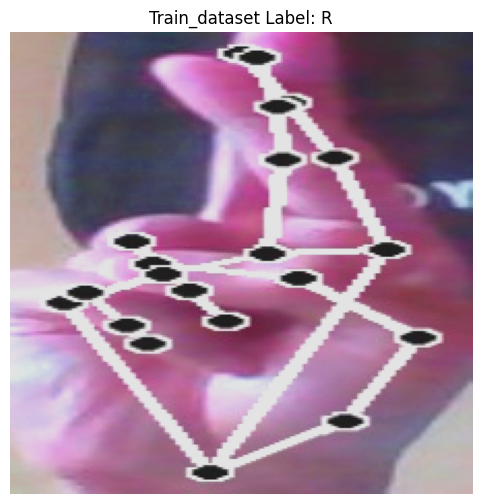

[ 2024-12-03 11:27:45 ] title_print_logger - INFO - =============VALID_DATASET_DATA INFO==============
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - shape-image: torch.Size([3, 224, 224])
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - dtype-image: torch.float32
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - max-intensity: 1.0
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - min-intensity: 0.0
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - label: 23 -> X
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - label-shape: torch.Size([])
[ 2024-12-03 11:27:45 ] dataset_inspect_logger - INFO - label-type: torch.int64


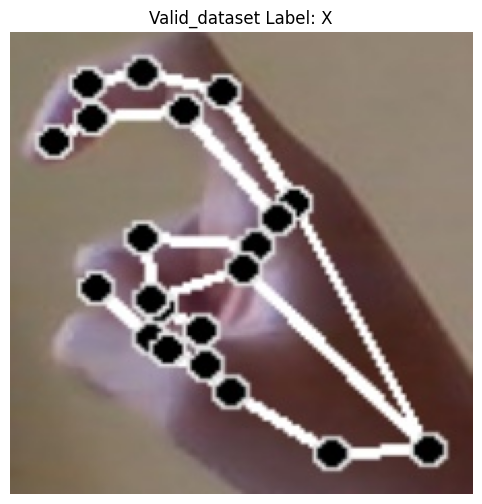

In [31]:
inspector.inspect(
    train_dataset=train_pt_datasets,
    valid_dataset=valid_pt_datasets,
)

## Building the model

### function

In [32]:
# Functional API - Define the forward pass
class TransferLearningModel(torch.nn.Module):
    def __init__(
            self, 
            base_model: torch.nn.Module=None, 
            num_classes: int=None
        ) -> None:
        
        super(TransferLearningModel, self).__init__()
        self.base_model = base_model
        self.base_model.features = base_model.features  # Feature extractor
        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        
        # Define a new fully cotorch.nnected layer
        self.fc = torch.nn.Linear(base_model.classifier.in_features, num_classes)

        # self.fc = torch.nn.Linear(base_model.classifier.in_features, 512)
        # self.relu = torch.nn.ReLU()  
        # self.dropout = torch.nn.Dropout(0.5)  
        # self.output_layer = torch.nn.Linear(512, num_classes)  
        
        # Activation based on number of classes
        self.activation = torch.nn.Sigmoid() if num_classes == 1 else torch.nn.Softmax(dim=1)

    def forward(
            self, 
            x: torch.Tensor
        ) -> torch.Tensor:
        
        # Pass through the feature extractor
        x = self.base_model.features(x)
        
        # Apply global average pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten the tensor
        
        # Pass through the classifier
        x = self.fc(x)

        # x = self.relu(x)
        # x = self.dropout(x)
        # x = self.output_layer(x)
        
        # Apply activation
        x = self.activation(x)
        return x

In [33]:
# Cek perangkat yang tersedia
def get_device():
	try:
		if torch.cuda.is_available():
			num_gpus = torch.cuda.device_count()
			if num_gpus > 1:
				return "multi-gpu", num_gpus
			else:
				return "single-gpu", 1
		return "cpu", 0
	except Exception as e:
		raise SIBIClassificationException(e, sys)

In [34]:
# Setup model untuk fleksibilitas
def setup_model(
        model: torch.nn.Module=None, 
        device_mode: str='cpu', 
        num_gpus: int=0
    ) -> tuple:
		
	try:
		if device_mode == "multi-gpu" and num_gpus > 1:
			torch.distributed.init_process_group(backend='nccl')
			local_rank = int(os.environ["LOCAL_RANK"])  # Rank di multi-proses
			torch.cuda.set_device(local_rank)
			device = torch.device(f"cuda:{local_rank}")
			model = model.to(device)
			model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank])
		elif device_mode == "single-gpu" and num_gpus == 1:
			device = torch.device("cuda:0")
			model = model.to(device)
		else:  # CPU
			device = torch.device("cpu")

		SETUP_MODEL_LOGGER.info(f"Is CUDA available: {log_manager.color_text(torch.cuda.is_available(), COLOR_TEXT)}")
		SETUP_MODEL_LOGGER.info(f"Number of GPUs: {log_manager.color_text((device_mode, num_gpus), COLOR_TEXT)}")
		SETUP_MODEL_LOGGER.info(f"CUDA Device Name: {log_manager.color_text(torch.cuda.get_device_name(0), COLOR_TEXT)}")
		SETUP_MODEL_LOGGER.info(f"Is model on CUDA: {log_manager.color_text(next(model.parameters()).is_cuda, COLOR_TEXT)}")

		return model, device

	except Exception as e:
		raise SIBIClassificationException(e, sys)

In [35]:
def get_dataloader(
        dataset_train: Dataset=None, 
        dataset_val: Dataset=None, 
        batch_size: int=32, 
        device_mode: str='cpu', 
        num_workers: int=0
    ) -> tuple:
    
	try:
		is_distributed = device_mode == "multi-gpu"  # True jika DDP

		if is_distributed:
			train_sampler = DistributedSampler(dataset_train)
			train_loader = DataLoader(
				dataset_train, 
				batch_size=batch_size, 
				sampler=train_sampler, 
				num_workers=num_workers,
				worker_init_fn=lambda _: np.random.seed(DATA_PREPROCESSING_CONFIG.seed)
			)
		else:
			train_loader = DataLoader(
				dataset_train, 
				batch_size=batch_size, 
				shuffle=True, 
				num_workers=num_workers,
				worker_init_fn=lambda _: np.random.seed(DATA_PREPROCESSING_CONFIG.seed)
			)

		val_loader = DataLoader(
			dataset_val, 
			batch_size=batch_size, 
			shuffle=False, 
			num_workers=num_workers,
			worker_init_fn=lambda _: np.random.seed(DATA_PREPROCESSING_CONFIG.seed)
		)


		custom_title_print("TRAIN DATASET")
		DATA_BATCHING_LOGGER.info(f"BATCH_SIZE: {log_manager.color_text(batch_size, COLOR_TEXT)}")
		DATA_BATCHING_LOGGER.info(f"Number of data: {log_manager.color_text(len(dataset_train), COLOR_TEXT)}")
		DATA_BATCHING_LOGGER.info(f"Number of data (after batch): {log_manager.color_text(len(train_loader), COLOR_TEXT)}")

		custom_title_print("VALIDATION DATASET")
		DATA_BATCHING_LOGGER.info(f"BATCH_SIZE: {log_manager.color_text(batch_size, COLOR_TEXT)}")
		DATA_BATCHING_LOGGER.info(f"Number of data: {log_manager.color_text(len(dataset_val), COLOR_TEXT)}")
		DATA_BATCHING_LOGGER.info(f"Number of data (after batch): {log_manager.color_text(len(val_loader), COLOR_TEXT)}")

		return train_loader, val_loader
	
	except Exception as e:
		raise SIBIClassificationException(e, sys)

### main program

In [36]:
MODEL_TRAINER_LOGGER.info("Loading pre-trained base model...")
# Pre-trained base model
base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Freeze the base model layers
for param in base_model.parameters():
    param.requires_grad = False

[ 2024-12-03 11:27:46 ] ModelTrainerLogger - INFO - Loading pre-trained base model...


In [51]:
MODEL_TRAINER_LOGGER.info("Instantiating model...")
# Set number of classes
num_classes = 1 if len(DATA_PREPROCESSING_CONFIG.label_list) == 2 else len(DATA_PREPROCESSING_CONFIG.label_list)

# Instantiate the model
model = TransferLearningModel(base_model, num_classes)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=MODEL_TRAINER.learning_rate)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

[ 2024-12-03 11:41:20 ] ModelTrainerLogger - INFO - Instantiating model...


In [52]:
device_mode, num_gpus = get_device()
model, device = setup_model(model, device_mode, num_gpus)

[ 2024-12-03 11:41:21 ] setup_model_logger - INFO - Is CUDA available: True
[ 2024-12-03 11:41:21 ] setup_model_logger - INFO - Number of GPUs: ('single-gpu', 1)
[ 2024-12-03 11:41:21 ] setup_model_logger - INFO - CUDA Device Name: NVIDIA GeForce MX150
[ 2024-12-03 11:41:21 ] setup_model_logger - INFO - Is model on CUDA: True


In [39]:
MODEL_TRAINER_LOGGER.info(f"Model Architecture: \n{summary(model, input_size=(MODEL_TRAINER.batch_size, 3, *DATA_PREPROCESSING_CONFIG.img_size[:2]))}")

[ 2024-12-03 11:27:47 ] ModelTrainerLogger - INFO - Model Architecture: 
Layer (type:depth-idx)                        Output Shape              Param #
TransferLearningModel                         [16, 26]                  --
├─DenseNet: 1-1                               --                        1,025,000
│    └─Sequential: 2-1                        [16, 1024, 7, 7]          --
│    │    └─Conv2d: 3-1                       [16, 64, 112, 112]        (9,408)
│    │    └─BatchNorm2d: 3-2                  [16, 64, 112, 112]        (128)
│    │    └─ReLU: 3-3                         [16, 64, 112, 112]        --
│    │    └─MaxPool2d: 3-4                    [16, 64, 56, 56]          --
│    │    └─_DenseBlock: 3-5                  [16, 256, 56, 56]         (335,040)
│    │    └─_Transition: 3-6                  [16, 128, 28, 28]         (33,280)
│    │    └─_DenseBlock: 3-7                  [16, 512, 28, 28]         (919,680)
│    │    └─_Transition: 3-8                  [16, 256, 14, 14

In [53]:
train_loader, val_loader = get_dataloader(train_pt_datasets, valid_pt_datasets, MODEL_TRAINER.batch_size, device_mode)

[ 2024-12-03 11:41:25 ] title_print_logger - INFO - ==================TRAIN DATASET===================
[ 2024-12-03 11:41:25 ] data_batching_logger - INFO - BATCH_SIZE: 16
[ 2024-12-03 11:41:25 ] data_batching_logger - INFO - Number of data: 4160
[ 2024-12-03 11:41:25 ] data_batching_logger - INFO - Number of data (after batch): 260
[ 2024-12-03 11:41:25 ] title_print_logger - INFO - ================VALIDATION DATASET================
[ 2024-12-03 11:41:25 ] data_batching_logger - INFO - BATCH_SIZE: 16
[ 2024-12-03 11:41:25 ] data_batching_logger - INFO - Number of data: 1040
[ 2024-12-03 11:41:25 ] data_batching_logger - INFO - Number of data (after batch): 65


## Training model

### function

In [41]:
# Fungsi untuk membuat ROC Curve
def plot_roc_curve(labels, predictions, class_names):
    fpr, tpr, roc_auc = {}, {}, {}
    plt.figure(figsize=(10, 6))

    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(labels == i, predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], label=f"Class {class_name} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.tight_layout()

    return plt

In [42]:
# Fungsi untuk log confusion matrix
def log_confusion_matrix(labels, predictions, class_names, normalize=False, figsize=(8, 6)):
    cm = confusion_matrix(labels, predictions)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2f"
    else:
        fmt = "d"
    title = 'Confusion Matrix'

    plt.figure(figsize=figsize)
    sns.heatmap(cm_df, annot=True, fmt=fmt, cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()

    return plt

In [43]:
# Fungsi untuk log classification report sebagai DataFrame
def log_classification_report(labels, predictions, class_names):
    # Generate classification report
    report_dict = classification_report(labels, predictions, target_names=class_names, output_dict=True)

    # Filter dan simpan metrik yang relevan dalam DataFrame
    report_data = []
    for class_name, metrics in report_dict.items():
        if isinstance(metrics, dict):  # Hanya ambil metrik untuk kelas, bukan 'accuracy'
            report_data.append([
                class_name, 
                metrics["precision"], 
                metrics["recall"], 
                metrics["f1-score"], 
                metrics["support"]
            ])

    # Membuat DataFrame dari data tersebut
    report_df = pd.DataFrame(report_data, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
    
    return report_df

In [44]:
# Fungsi untuk log sampel prediksi
def log_sample_predictions(inputs, labels, outputs, class_names, sample_count=1):
    predictions = torch.argmax(outputs, dim=1)
    confidences = torch.max(torch.softmax(outputs, dim=1), dim=1).values
    
    for i in range(min(len(inputs), sample_count)):
        img = inputs[i].permute(1, 2, 0).cpu().numpy()
        label = class_names[labels[i].item()]
        prediction = class_names[predictions[i].item()]
        confidence = confidences[i].item() * 100

        wandb.log({
            "sample_prediction": wandb.Image(img, caption=f"Label: {label}, Pred: {prediction} ({confidence:.2f}%)")
        })


In [45]:
def train_step(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    optim: torch.optim.Optimizer,
    # epoch: int,
    # num_epochs: int
) -> tuple:

	model.train()
	train_loss, train_acc, total_train = 0.0, 0.0, 0

  # with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as train_bar:
  # for inputs, labels in train_loader:
	for inputs, labels in tqdm(train_loader, total=(len(train_loader)), desc="Training"):
		inputs, labels = inputs.to(device), labels.to(device)

		optim.zero_grad()
		outputs = model(inputs)

		loss = criterion(outputs, labels)
		loss.backward()
		optim.step()

		train_loss += loss.item()
		_, predicted = torch.max(outputs, 1)
		train_acc += (predicted == labels).sum().item()
		total_train += labels.size(0)

   	 	# train_bar.set_postfix(loss=train_loss/total_train, acc=train_acc/total_train)

	avg_train_loss = train_loss / len(train_loader)
	avg_train_acc = train_acc / total_train

	return avg_train_loss, avg_train_acc

In [54]:
def valid_step(
    model: torch.nn.Module,
    val_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    class_names: list
) -> tuple:

	model.eval()
	val_loss, val_acc, total_val = 0.0, 0.0, 0
	all_labels, all_predictions = [], []

	with torch.inference_mode():
		for inputs, labels in tqdm(val_loader, total=(len(val_loader)), desc="Validating"):
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			loss = criterion(outputs, labels)

			val_loss += loss.item()
			_, predicted = torch.max(outputs, 1)
			val_acc += (predicted == labels).sum().item() 
			total_val += labels.size(0)

			# Simpan label dan prediksi untuk ROC Curve
			all_labels.append(labels.cpu().numpy())
			all_predictions.append(outputs.cpu().numpy())

			# Log sampel prediksi
			# log_sample_predictions(inputs, labels, outputs, DATA_PREPROCESSING_CONFIG.label_list)

	avg_val_loss = val_loss / len(val_loader)
	avg_val_acc = val_acc / total_val

	# Log ROC Curve
	all_labels = np.concatenate(all_labels)

	all_predictions = np.vstack(all_predictions)
	roc_plot = plot_roc_curve(all_labels, all_predictions, class_names)
	wandb.log({"ROC Curve": wandb.Image(roc_plot)})

	# Log Confusion Matrix
	predictions = np.argmax(all_predictions, axis=1)
	cf_plot = log_confusion_matrix(all_labels, predictions, class_names)
	wandb.log({"Confusion Matrix": wandb.Image(cf_plot)})

	# Log Classification Report
	# classification_report = log_classification_report(all_labels, predictions, class_names)
	# wandb.log({"classification_report": wandb.Table(dataframe=classification_report)})

	return avg_val_loss, avg_val_acc

### main program

In [55]:
# Inisialisasi W&B
wandb.init(
    project="SIBI_model_experimentation",
    config={
        "epochs": MODEL_TRAINER.epochs,
        "batch_size": MODEL_TRAINER.batch_size,
        "learning_rate": MODEL_TRAINER.learning_rate,
        "architecture": model.__class__.__name__,
        "criterion": criterion.__class__.__name__,
        "optimizer": optimizer.__class__.__name__,
    }
)
config = wandb.config  # Shortcut untuk mengambil hyperparameter

[ 2024-12-03 11:41:46 ] model_training_logger - INFO - Epoch 1 of 3
Validating: 100%|██████████| 65/65 [00:21<00:00,  2.98it/s]
[ 2024-12-03 11:45:01 ] model_training_logger - INFO - Epoch 1 Summary:
[ 2024-12-03 11:45:01 ] model_training_logger - INFO - Best validation loss: 2.6001 in artifacts/<model_name>/results/model/best_model.pth
[ 2024-12-03 11:45:01 ] model_training_logger - INFO - Saving best model for epoch: 1
[ 2024-12-03 11:45:02 ] model_training_logger - INFO - train_loss: 2.6742938280105593, train_acc: 0.7786057692307692
[ 2024-12-03 11:45:02 ] model_training_logger - INFO - valid_loss: 2.6001, valid_acc: 0.8606
[ 2024-12-03 11:45:02 ] model_training_logger - INFO - ===========================================================================
[ 2024-12-03 11:45:02 ] model_training_logger - INFO - Epoch 2 of 3
Validating: 100%|██████████| 65/65 [00:20<00:00,  3.18it/s]
[ 2024-12-03 11:48:34 ] model_training_logger - INFO - Epoch 2 Summary:
[ 2024-12-03 11:48:34 ] model_trai

epoch,▁▅█
epoch_time,▁██
train_acc,▁██
train_loss,█▂▁
valid_acc,▁▄█
valid_loss,█▃▁
epoch,3
epoch_time,212.07795
train_acc,0.98846
train_loss,2.3618
valid_acc,0.87115


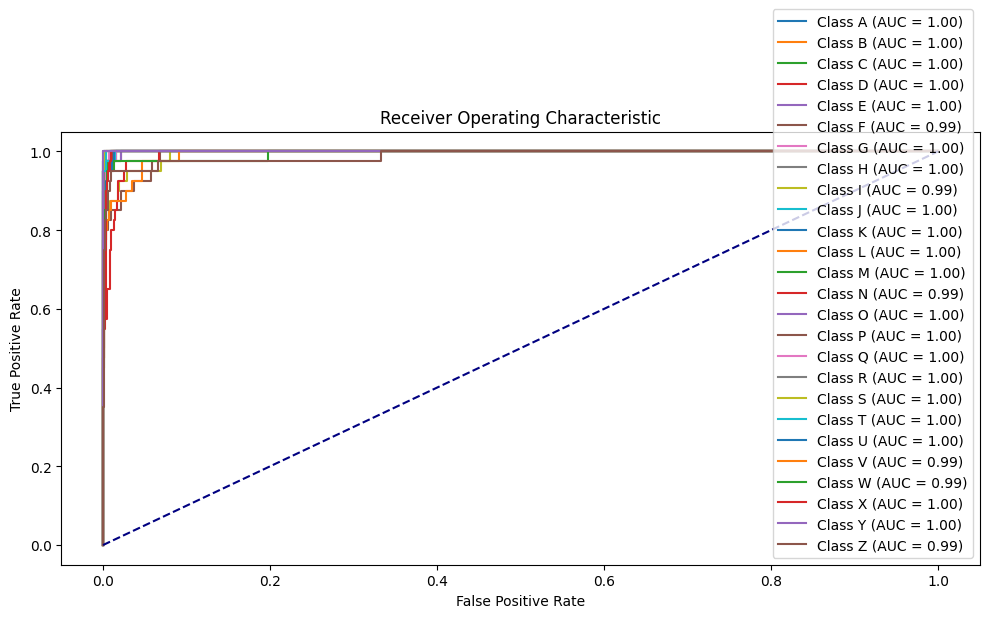

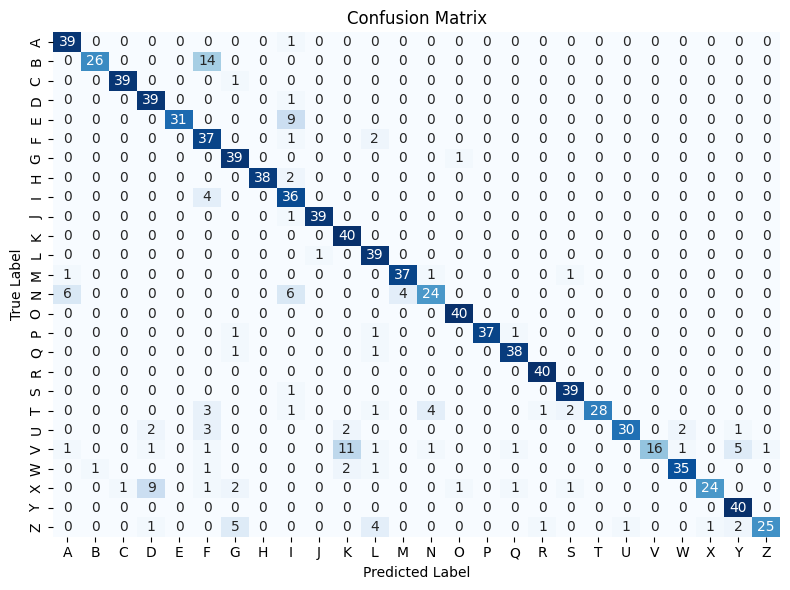

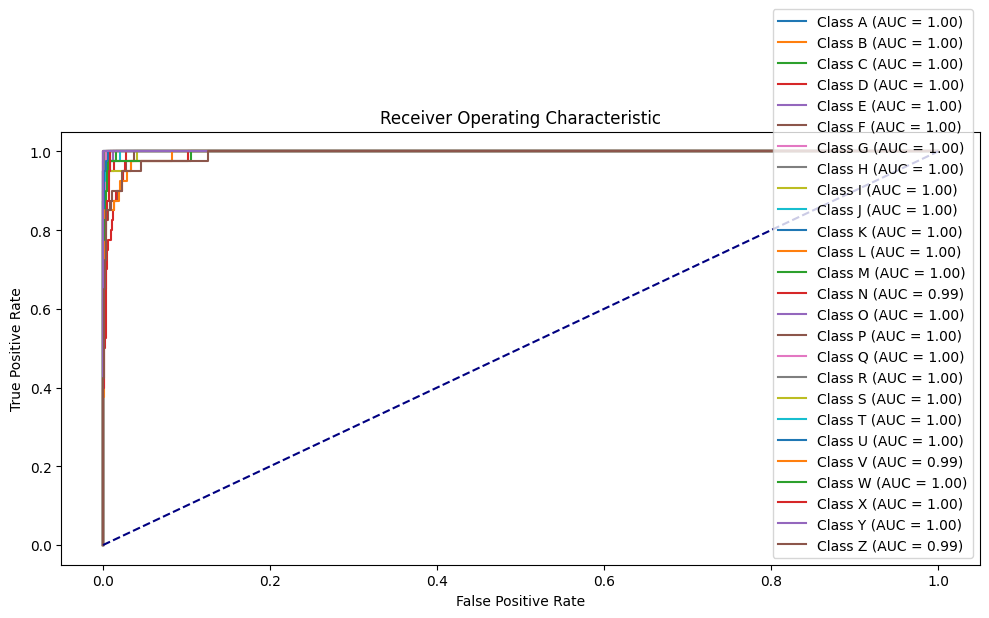

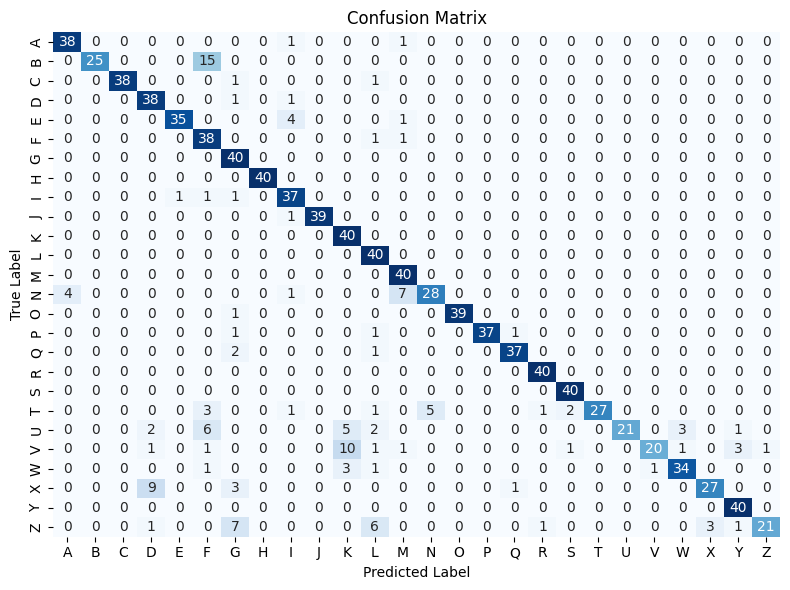

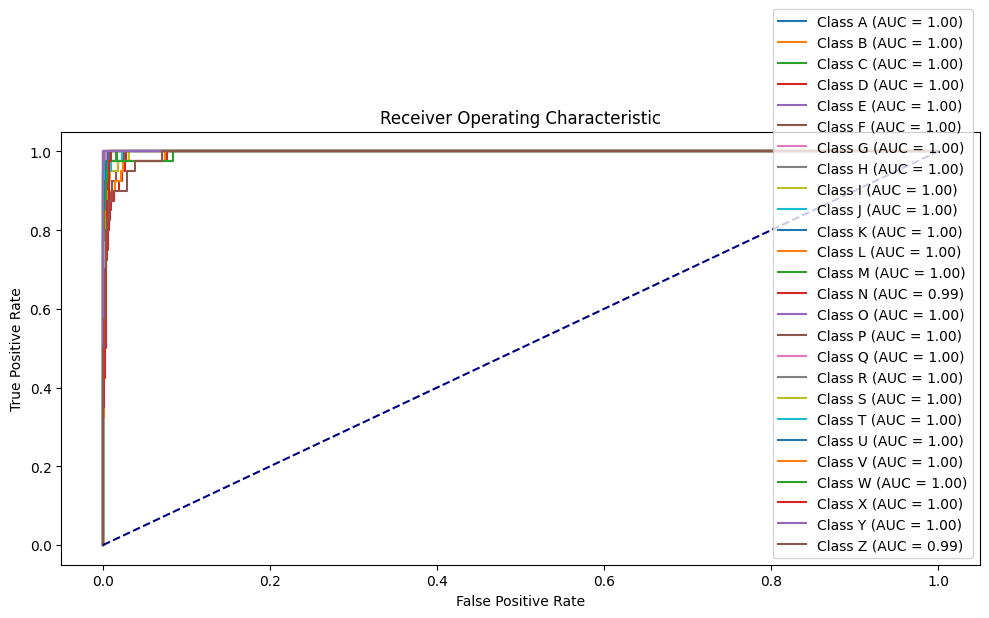

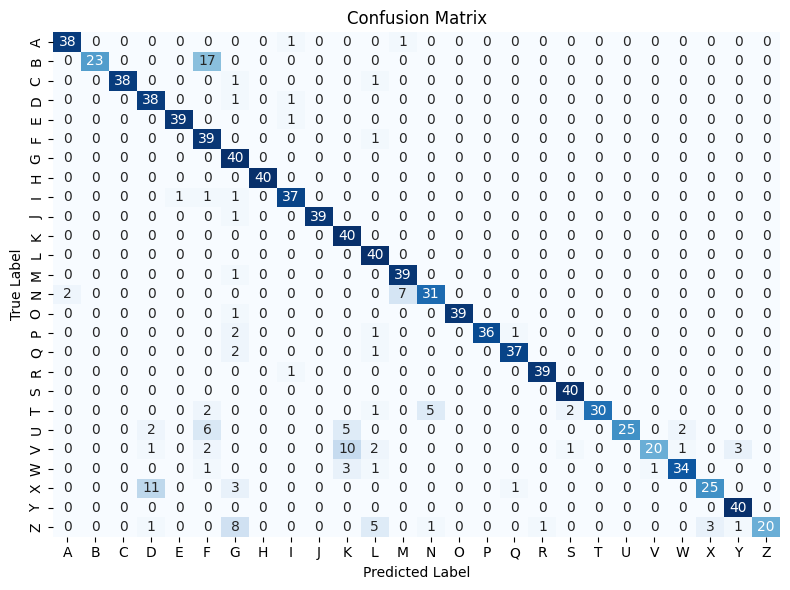

In [56]:
best_val_loss = float('inf')
train_loss_list, valid_loss_list = [], []
train_acc_list, valid_acc_list = [], []
epoch_metrics = []

for epoch in range(config.epochs):
	MODEL_TRAINING_LOGGER.info(f"Epoch {log_manager.color_text(epoch+1, COLOR_TEXT)} of {log_manager.color_text(MODEL_TRAINER.epochs, COLOR_TEXT)}")

	start_time = time.time()

	train_loss, train_acc = train_step(model, train_loader, criterion, optimizer)
	valid_loss, valid_acc = valid_step(model, val_loader, criterion, DATA_PREPROCESSING_CONFIG.label_list)

	epoch_time = time.time() - start_time

	# Logging ke W&B
	wandb.log(
		{
			"epoch": epoch + 1,
			"train_loss": train_loss,
			"train_acc": train_acc,
			"valid_loss": valid_loss,
			"valid_acc": valid_acc,
			"epoch_time": epoch_time
		}
	)

	MODEL_TRAINING_LOGGER.info(f"Epoch {log_manager.color_text(epoch+1, COLOR_TEXT)} Summary:")
	if valid_loss < best_val_loss:
		best_val_loss = valid_loss
		# torch.save(model.state_dict(), MODEL_TRAINER.model_file_path)
		MODEL_TRAINING_LOGGER.info(f"Best validation loss: {log_manager.color_text(f'{best_val_loss:.4f}', COLOR_TEXT)} in {log_manager.color_text(MODEL_TRAINER.model_file_path, COLOR_TEXT)}")
		MODEL_TRAINING_LOGGER.info(f"Saving best model for epoch: {log_manager.color_text(epoch+1, COLOR_TEXT)}")

	train_loss_list.append(train_loss)
	valid_loss_list.append(valid_loss)
	train_acc_list.append(train_acc)
	valid_acc_list.append(valid_acc)

	lr_scheduler.step()

	# Simpan data epoch
	epoch_metrics.append([epoch + 1, train_acc, valid_acc, train_loss, valid_loss, epoch_time])

	MODEL_TRAINING_LOGGER.info(f"train_loss: {log_manager.color_text(train_loss, COLOR_TEXT)}, train_acc: {log_manager.color_text(train_acc, COLOR_TEXT)}")
	MODEL_TRAINING_LOGGER.info(f"valid_loss: {log_manager.color_text(f'{valid_loss:.4f}', COLOR_TEXT)}, valid_acc: {log_manager.color_text(f'{valid_acc:.4f}', COLOR_TEXT)}")
	MODEL_TRAINING_LOGGER.info('='*75)

# Tabel epoch setelah pelatihan selesai
epoch_df = pd.DataFrame(epoch_metrics, columns=["Epoch", "Train Accuracy", "Valid Accuracy", "Train Loss", "Valid Loss", "Epoch Time (s)"])
wandb.log({"epoch_table": wandb.Table(dataframe=epoch_df)})

wandb.finish()

In [49]:
# sample = 3

# for n, (feature, label) in enumerate(val_loader):
#   if n >= sample:
#     break
#   print(f'feature map allocation: {feature.device}')
#   pred = model(feature.to(device))
#   print(pred.argmax(dim=1))
#   print(label)
#   print('='*75)

In [50]:
log_manager.clean_log_file()